In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import rdata
frequency = rdata.read_rda("data//fremotor1freq0304a.rda")
premium = rdata.read_rda("data//fremotor1prem0304a.rda")
severity = rdata.read_rda("data//fremotor1sev0304a.rda")
freq_df = frequency["fremotor1freq0304a"]
prem_df = premium["fremotor1prem0304a"]
sev_df = severity["fremotor1sev0304a"]
sev_df["OccurDate"] = pd.to_datetime(sev_df["OccurDate"], unit="D", origin="unix")
sev_df["OccurYear"] = sev_df["OccurDate"].dt.year
prem_df["DrivAgeBins"] = pd.cut(prem_df["DrivAge"],bins=20).map(lambda x: "(%s,%s]" % (x.left, x.right))

/opt/conda/lib/python3.12/site-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "Date". The underlying R object is returned instead.
  warnings.warn(


In [3]:
mask = sev_df["Guarantee"] == "Windscreen"
damage_df = sev_df.loc[mask,:]

In [4]:
enriched_df = pd.merge(prem_df, damage_df, left_on=["IDpol","Year"], right_on=["IDpol","OccurYear"])

In [5]:
vehclass_cat = ["Cheapest", "Cheaper", "Cheap", "Medium low", "Medium", "Medium high", "Expensive","More expensive", "Most expensive"]
vehpower_cat = ["P%s" % x for x in range(2,18)]
len(vehpower_cat)

16

In [6]:
enriched_df["VehClassOrd"] = enriched_df["VehClass"].map(lambda x: vehclass_cat.index(x))
enriched_df["VehPowerOrd"] = enriched_df["VehPower"].map(lambda x: vehpower_cat.index(x))

In [15]:
def vehclass_factor(ordinal):
    if ordinal < 3:
        return 1/9
    return (1+ordinal)/9

def vehpower_factor(ordinal):
    return (1+ordinal)/16

def calc_damage(row):
    return (5000*(vehclass_factor(row["VehClassOrd"])*vehpower_factor(row["VehPowerOrd"]))+np.random.random()*1000)

np.random.seed(42)
enriched_df["Damage"] = enriched_df.apply(calc_damage, axis=1)

In [16]:
X = enriched_df.loc[:, ["VehClassOrd","VehPowerOrd"]].values
y = enriched_df["Damage"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
from sklearn.tree import DecisionTreeRegressor
clf_tree = DecisionTreeRegressor(max_depth=10).fit(X_train, y_train)
print("The Tree model score is %.2f%%" % (clf_tree.score(X_test, y_test)*100))
y_tree = clf_tree.predict(X_test)

The Tree model score is 88.79%


In [18]:
from sklearn.linear_model import LinearRegression
clf_lin = LinearRegression().fit(X_train, y_train)
print("The Linear model score is %.2f%%" % (clf_lin.score(X_test, y_test)*100))
y_lin = clf_lin.predict(X_test)

The Linear model score is 72.24%


In [19]:
def perc_to_decile(val):
    if val == 1.0:
        return 10
    return int(val*10)+1

In [20]:
pred_df = pd.DataFrame({"Actual": y_test, "Tree": y_tree, "Lin": y_lin})
pred_df.sort_values("Tree", inplace=True)
pred_df["DecileTree"] = pred_df["Tree"].rank(pct=True).map(perc_to_decile)
pred_df.sort_values("Lin", inplace=True)
pred_df["DecileLin"] = pred_df["Lin"].rank(pct=True).map(perc_to_decile)

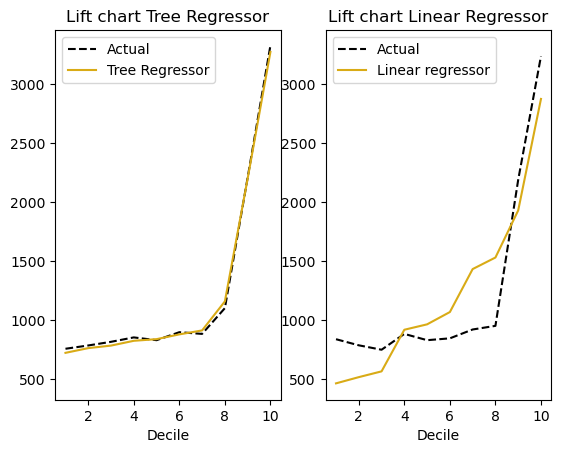

In [24]:
fig, ax = plt.subplots(1,2)

pred_df.loc[:,["DecileTree","Actual", "Tree"]].groupby("DecileTree").mean().plot(color = ["black", "#d9ab16"], style=["--","-"], ax=ax[0])
ax[0].legend(["Actual", "Tree Regressor"])
ax[0].set_title("Lift chart Tree Regressor")
tree_min, tree_max = ax[0].get_ylim()

pred_df.loc[:,["DecileLin","Actual", "Lin"]].groupby("DecileLin").mean().plot(color = ["black", "#d9ab16"], style=["--","-"], ax=ax[1])
ax[1].legend(["Actual", "Linear regressor"])
ax[1].set_title("Lift chart Linear Regressor")
lin_min, lin_max = ax[1].get_ylim()
y_min = min(tree_min, lin_min)
y_max = max(tree_max, lin_max)
ax[0].set_ylim(y_min, y_max)
ax[0].set_xlabel("Decile")
ax[1].set_ylim(y_min, y_max)
ax[1].set_xlabel("Decile")
plt.show()

In [37]:
pred_df = pd.DataFrame({"Actual": y_test, "Tree": y_tree, "Lin": y_lin})
pred_df["Model/Current"] = pred_df["Tree"]/pred_df["Lin"]
pred_df.sort_values("Model/Current", inplace=True)
pred_df["Decile"] = pred_df["Model/Current"].rank(pct=True).map(perc_to_decile)


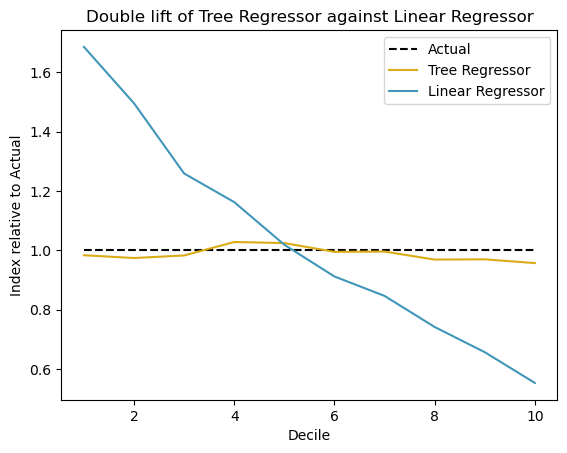

In [40]:
double_lift_df = pred_df.loc[:,["Decile","Actual", "Tree","Lin"]].groupby("Decile").mean()
double_lift_df["ActualIndex"] = 1
double_lift_df["TreeIndex"] = double_lift_df["Tree"]/double_lift_df["Actual"]
double_lift_df["LinIndex"] = double_lift_df["Lin"]/double_lift_df["Actual"]
double_lift_df.loc[:, [ "ActualIndex", "TreeIndex", "LinIndex"]].plot(color = ["black", "#d9ab16", "#4096b8"], style=["--","-","-"])
plt.legend(["Actual","Tree Regressor", "Linear Regressor"])
plt.title("Double lift of Tree Regressor against Linear Regressor")
plt.ylabel("Index relative to Actual")
plt.show()